In [26]:
import torch as th
import torch.nn as nn
import numpy as np
import matplotlib.pyplot as plt

from pprint import pprint
from Algorithms.sac import config

# 0. Plot Setting

In [27]:
import seaborn as sb
import matplotlib

sb.set_style('whitegrid')

FONTSIZE = 10
matplotlib.rcParams["figure.figsize"] = (10, 5)
matplotlib.rcParams["figure.dpi"] = 100
matplotlib.rcParams["figure.titlesize"] = FONTSIZE
matplotlib.rcParams["legend.fontsize"] = FONTSIZE
matplotlib.rcParams["xtick.labelsize"] = FONTSIZE
matplotlib.rcParams["ytick.labelsize"] = FONTSIZE
matplotlib.rcParams["axes.labelsize"] = FONTSIZE
matplotlib.rcParams["axes.titlesize"] = FONTSIZE
matplotlib.rcParams["savefig.bbox"] = "tight"
matplotlib.rcParams["savefig.pad_inches"] = 0.1
matplotlib.rcParams["lines.linewidth"] = 2
matplotlib.rcParams["axes.linewidth"] = 1.6

# 1. Model Setting

## 1.1 Load Config

In [28]:
# env_kwargs, model_kwargs, learn_kwargs = config.load_config('../logs/tb_logs/sac_220619-0122_1/config.yaml')
env_kwargs, model_kwargs, learn_kwargs = config.load_config('tmp_config.yaml')

env 'BSMarket was created!
env 'BSMarket was created!


In [43]:
ntb_mode = True
double_sac = False

env_kwargs.update({
    'drift': 1.0,
    'reward_fn': 'mean var',
    'reward_fn_kwargs': {},
    'reward_mode': 'pnl'
})

model_kwargs.update({
    'buffer_size': 300,
    'learning_starts': 300,
    'batch_size': 15,
    'target_entropy' : 000.0,      # target log_prob => log_prob는 entropy가 작을수록 커진다
    'ent_coef': "auto_1e-6",
    'verbose': 0
})

if double_sac:
    model_kwargs.update({
    'mean_coeff': 1.0,
    'std_coeff': 0.02,
    })

model_kwargs['policy_kwargs'].update({
    'ntb_mode': ntb_mode,

})

learn_kwargs.update({
    'total_timesteps': 5000

})

actor_net_kwargs = {'bn_kwargs': {'num_features': env_kwargs['n_assets']}}
critic_net_kwargs = {'bn_kwargs': {'num_features': env_kwargs['n_assets']}}

if ntb_mode:
    model_kwargs['policy_kwargs'].update({
        'net_arch': {'pi': [(nn.BatchNorm1d, 'bn'), 32, 32,],
                     'qf': [(nn.BatchNorm1d, 'bn'), 16],
                     'qf2': [(nn.BatchNorm1d, 'bn'), 4]},
        'actor_net_kwargs': actor_net_kwargs,
        'critic_net_kwargs': critic_net_kwargs,
    })

    model_kwargs['policy_kwargs']['features_extractor_kwargs'].update({
        'features_out': 64,
        'net_arch': [32]
    })

else:
    model_kwargs['policy_kwargs'].update({
        'net_arch': {'pi': [(nn.BatchNorm1d, 'bn'), 16, 16, None],
                     'qf': [(nn.BatchNorm1d, 'bn'), 16],
                     'qf2': [(nn.BatchNorm1d, 'bn'),4]},
        'actor_net_kwargs': actor_net_kwargs,
        'critic_net_kwargs': critic_net_kwargs,
    })

    model_kwargs['policy_kwargs']['features_extractor_kwargs'].update({
        'features_out': 64,
        'net_arch': [32,]
    })

In [44]:
config.reconstruct_config(env_kwargs, model_kwargs, learn_kwargs)

env 'BSMarket was created!
model_kwargs['env']: <BSMarket instance>
env 'BSMarket was created!
learn_kwargs['eval_env']: <BSMarketEval instance>
learn_kwargs['tb_log_name']: sac_220619-2349
learn_kwargs['eval_log_path']: ../logs/tb_logs/sac_220619-2349_1


In [45]:
pprint(env_kwargs)

{'cost': 0.02,
 'dividend': 0.0,
 'drift': 1.0,
 'freq': 1,
 'gen_name': 'gbm',
 'init_price': 1.0,
 'maturity': 30,
 'n_assets': 1000,
 'payoff': 'european',
 'payoff_coeff': 1.0,
 'period_unit': 365,
 'reward_fn': 'mean var',
 'reward_fn_kwargs': {},
 'reward_mode': 'pnl',
 'risk_free_interest': 0.0,
 'strike': 1.0,
 'volatility': 0.2}


In [46]:
pprint(model_kwargs)

{'action_noise': None,
 'batch_size': 15,
 'buffer_size': 300,
 'create_eval_env': False,
 'device': 'auto',
 'ent_coef': 'auto_1e-6',
 'env': <Env.env.BSMarket object at 0x0000014AFF8F97F0>,
 'gamma': 0.99,
 'gradient_steps': -1,
 'learning_rate': <function lr_schedule at 0x0000014AFF5AB670>,
 'learning_starts': 300,
 'mean_coeff': 1.0,
 'optimize_memory_usage': False,
 'policy': <class 'Algorithms.sac.policies.SACPolicy'>,
 'policy_kwargs': {'activation_fn': <class 'torch.nn.modules.activation.ReLU'>,
                   'actor_net_kwargs': {'bn_kwargs': {'num_features': 1000}},
                   'clip_mean': 2.0,
                   'critic_net_kwargs': {'bn_kwargs': {'num_features': 1000}},
                   'features_extractor_class': <class 'Env.feature_extractor.MarketObsExtractor'>,
                   'features_extractor_kwargs': {'activation_fn': <class 'torch.nn.modules.activation.ReLU'>,
                                                 'features_in': 4,
                     

In [47]:
pprint(learn_kwargs)

{'callback': <Algorithms.sac.callbacks.ReportCallbacks object at 0x0000014A9CAF5070>,
 'eval_env': <Env.env.BSMarketEval object at 0x0000014B8B4C31F0>,
 'eval_freq': 30,
 'eval_log_path': '../logs/tb_logs/sac_220619-2349_1',
 'log_interval': 30,
 'n_eval_episodes': 1,
 'reset_num_timesteps': True,
 'tb_log_name': 'sac_220619-2349',
 'total_timesteps': 5000}


## 1.2 Make env, model

In [48]:
from Algorithms.sac import SAC as QSAC
from stable_baselines3.sac import SAC
# from Algorithms.ddpg.double_ddpg import DDPG

print(f'double_sac: {double_sac}')
if double_sac:
    model = QSAC(**model_kwargs)
else:
    model = SAC(**model_kwargs)

In [49]:
model.policy

SACPolicy(
  (actor): CustomActor(
    (features_extractor): MarketObsExtractor(
      (layers): Sequential(
        (0): BatchNorm1d(1000, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (1): Linear(in_features=4, out_features=32, bias=True)
        (2): ReLU()
        (3): BatchNorm1d(1000, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (4): Linear(in_features=32, out_features=64, bias=True)
        (5): ReLU()
      )
    )
    (latent_pi): Sequential(
      (0): BatchNorm1d(1000, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (1): Linear(in_features=64, out_features=32, bias=True)
      (2): ReLU()
      (3): Linear(in_features=32, out_features=32, bias=True)
    )
    (mu): Sequential(
      (0): Linear(in_features=32, out_features=2, bias=True)
    )
    (log_std): Sequential(
      (0): Linear(in_features=32, out_features=1, bias=True)
    )
    (flatten): Flatten(start_dim=-2, end_dim=-1)
  )
  (critic): Cu

# 2. Learning

In [50]:
model = model.learn(**learn_kwargs)

[Training Start]
Eval num_timesteps=30, episode_reward=-0.05 +/- 0.00
Episode length: 30.00 +/- 0.00
New best mean reward!
Eval num_timesteps=60, episode_reward=-0.05 +/- 0.00
Episode length: 30.00 +/- 0.00
New best mean reward!
Eval num_timesteps=90, episode_reward=-0.05 +/- 0.00
Episode length: 30.00 +/- 0.00
Eval num_timesteps=120, episode_reward=-0.05 +/- 0.00
Episode length: 30.00 +/- 0.00
Eval num_timesteps=150, episode_reward=-0.05 +/- 0.00
Episode length: 30.00 +/- 0.00
New best mean reward!
Eval num_timesteps=180, episode_reward=-0.05 +/- 0.00
Episode length: 30.00 +/- 0.00
Eval num_timesteps=210, episode_reward=-0.05 +/- 0.00
Episode length: 30.00 +/- 0.00
Eval num_timesteps=240, episode_reward=-0.05 +/- 0.00
Episode length: 30.00 +/- 0.00
Eval num_timesteps=270, episode_reward=-0.05 +/- 0.00
Episode length: 30.00 +/- 0.00
Eval num_timesteps=300, episode_reward=-0.05 +/- 0.00
Episode length: 30.00 +/- 0.00
Eval num_timesteps=330, episode_reward=-0.05 +/- 0.00
Episode length: 

In [37]:
config.save_config(f'{learn_kwargs["eval_log_path"]}/config.yaml', env_kwargs, model_kwargs, learn_kwargs)

<BSMarket instance> will be save as name. env_kwargs not in kwargs!
<BSMarketEval instance> will be save as name. eval_env_kwargs not in kwargs!
<Algorithms.sac.callbacks.ReportCallbacks object at 0x0000014A9CAF5070> will be save as name. callback_kwargs not in kwargs!
../logs/tb_logs/sac_220619-2330_1/config.yaml was saved.


# 3. P&L Evaluation

In [38]:
model = model.load('../logs/tb_logs/sac_220619-2312_1'+'/best_model')
# model = model.load(learn_kwargs['eval_log_path'] + '/best_model')
print(learn_kwargs['eval_log_path'] + '/best_model')

../logs/tb_logs/sac_220619-2330_1/best_model


In [39]:
eval_env = learn_kwargs['eval_env']
eval_env.reward_mode = 'pnl'

In [13]:
# zero_pnl = np.load('best_results/zero_pnl.npy')
# random_pnl = np.load('best_results/random_pnl.npy')

# rl_pnl = np.load('best_results/pnl_train/rl_pnl_drift.npy')
# rl_cash = np.load('best_results/pnl_train/rl_cash.npy')

# ntb_pnl = np.load('best_results/pnl_train/ntb_pnl.npy')
# ntb_cash = np.load('best_results/pnl_train/ntb_cash.npy')

In [40]:
zero_pnl = np.load('best_results/zero_pnl.npy')
random_pnl = np.load('best_results/random_pnl.npy')

In [41]:
rl_pnl = eval_env.eval(model, 'pnl', 100)

In [16]:
# ntb_pnl = np.mean([eval_env.pnl_eval(model) for _ in range(30)], axis=0)

In [17]:
def pnl_reward(pnl):
    mean = np.mean(pnl)
    std = np.std(pnl)
    return [mean - 0.02 * std , mean, std]

def sharpe_ratio(pnl):
    return pnl.mean()/pnl.std()

def var(pnl, ratio):
    losses = np.sort(-pnl)
    boundary = int(np.ceil(losses.shape[-1]*ratio))
    return losses[boundary]

def cvar(pnl, ratio=0.95):
    losses = np.sort(-pnl)
    boundary = int(np.ceil(losses.shape[-1]*ratio))
    return np.mean(losses[boundary:], axis=-1)

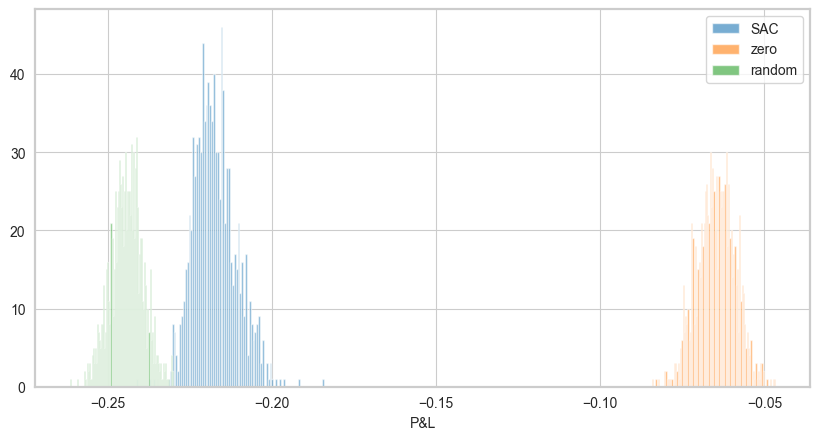

rl pnl: 		[-0.2176 -0.2175  0.0065]
zero pnl: 		[-0.0649 -0.0648  0.0058]
random pnl: 	[-0.2445 -0.2444  0.0049]

rl cvar:		0.22951
zero cvar:		0.07669
random cvar:	0.25457



In [42]:
plt_kwargs = {'bins': 100,
              # 'range': (-0.06, -0.03),
              'alpha': 0.6}

plt.xlabel('P&L')
# plt.hist(ntb_pnl,**plt_kwargs, label='DDPG+NTB')
plt.hist(rl_pnl, **plt_kwargs, label='SAC')
plt.hist(zero_pnl,**plt_kwargs, label='zero')
plt.hist(random_pnl,**plt_kwargs, label='random')
# plt.hist(delta_pnl,**plt_kwargs, label='delta')
plt.legend()
plt.show()

# print(f'ntb pnl: \t\t{np.round(pnl_reward(ntb_pnl), 4)}')
print(f'rl pnl: \t\t{np.round(pnl_reward(rl_pnl), 4)}')
print(f'zero pnl: \t\t{np.round(pnl_reward(zero_pnl), 4)}')
print(f'random pnl: \t{np.round(pnl_reward(random_pnl), 4)}')
# print(f'delta pnl: \t\t{np.round(pnl_reward(delta_pnl), 4)}')
print()

# print(f'ntb cvar:\t\t{cvar(ntb_pnl):.5f}')
print(f'rl cvar:\t\t{cvar(rl_pnl):.5f}')
print(f'zero cvar:\t\t{cvar(zero_pnl):.5f}')
print(f'random cvar:\t{cvar(random_pnl):.5f}')
# print(f'delta cvar:\t\t{cvar(delta_pnl):.5f}')
print()

In [28]:
from stable_baselines3.common.evaluation import evaluate_policy

ep_rewards, ep_lens = evaluate_policy(model, eval_env,
                                      n_eval_episodes=1, render=False, deterministic=True,
                                      return_episode_rewards=True,
                                      warn=True,
                                      callback=None)

C:\Users\bluesun\anaconda3\envs\rl\lib\site-packages\stable_baselines3\common\evaluation.py:65: UserWarning: Evaluation environment is not wrapped with a ``Monitor`` wrapper. This may result in reporting modified episode lengths and rewards, if other wrappers happen to modify these. Consider wrapping environment first with ``Monitor`` wrapper.
  warnings.warn(


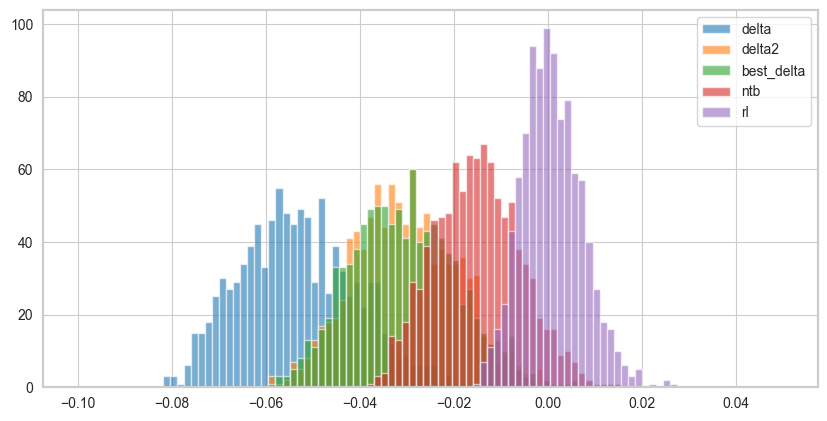

In [17]:
plt.hist(delta_pnl, bins=100, range=(-0.1, 0.05), alpha=0.6, label='delta')
plt.hist(np.mean([eval_env.delta_eval2() for _ in range(30)], axis=0), bins=100, range=(-0.1, 0.05), alpha=0.6, label='delta2')
plt.hist(np.load('best_results/delta_pnl.npy'), bins=100, range=(-0.1, 0.05), alpha=0.6, label='best_delta')
plt.hist(ntb_pnl, bins=100, range=(-0.1, 0.05), alpha=0.6, label='ntb')
plt.hist(rl_pnl, bins=100, range=(-0.1, 0.05), alpha=0.6, label='rl')
plt.legend()
plt.show()

In [2]:
delta_pnl = np.load('../ddpg/best_results/delta_pnl.npy')
ddpg_pnl = np.load('../ddpg/best_results/rl_pnl.npy')
ddpg_ntb_pnl = np.load('../ddpg/best_results//ntb_pnl.npy')
sac_ntb_pnl = np.load('best_results/ntb_pnl.npy')
sac_pnl = np.load('best_results/sac_pnl.npy')

In [7]:
delta_pnl.std()

0.01135903044001691

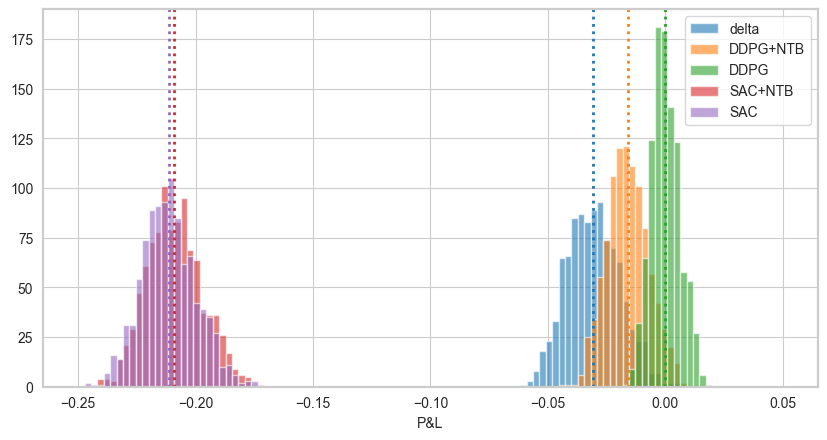

In [13]:
plt.xlabel('P&L')
plot_range = (-0.25, 0.05)
bins = 110

plt.hist(delta_pnl, bins=bins, range=plot_range, alpha=0.6, label='delta')
plt.axvline(delta_pnl.mean(), ls=':', lw=2, c='C0')

plt.hist(ddpg_ntb_pnl, bins=bins, range=plot_range, alpha=0.6, label='DDPG+NTB')
plt.axvline(ddpg_ntb_pnl.mean(), ls=':', lw=2, c='C1')

plt.hist(ddpg_pnl, bins=bins, range=plot_range, alpha=0.6, label='DDPG')
plt.axvline(ddpg_pnl.mean(), ls=':', lw=2, c='C2')

plt.hist(sac_ntb_pnl, bins=bins, range=plot_range, alpha=0.6, label='SAC+NTB')
plt.axvline(sac_ntb_pnl.mean(), ls=':', lw=2, c='C3')

plt.hist(sac_pnl, bins=bins, range=plot_range, alpha=0.6, label='SAC')
plt.axvline(sac_pnl.mean(), ls=':', lw=2, c='C4')

plt.legend()
plt.show()

In [18]:
def r1(pnl):
    return pnl.mean()/pnl.std()

def performance_print(pnl, name):
    print(f'{name}:\t{"" if len(name)>5 else "    "}{pnl.mean():.4f}\t{pnl.std():.4f}\t\t{r1(pnl):.4f}')

# print(f'delta:\t\t{delta_pnl.mean():.4f}\t{delta_pnl.std():.4f}\t\t{r1(delta_pnl):.4f}')
# print(f'ddpg+ntb:\t{ddpg_ntb_pnl.mean():.4f}\t{ddpg_ntb_pnl.std():.4f}\t\t{r1(ddpg_ntb_pnl)}')
# print(f'ddpg:\t\t{ddpg_pnl.mean():.4f}\t{ddpg_pnl.std():.4f}')
# print(f'sac+ntb:\t{sac_ntb_pnl.mean():.4f}\t{sac_ntb_pnl.std():.4f}')
# print(f'sac:\t\t{sac_pnl.mean():.4f}\t{sac_pnl.std():.4f}')

performance_print(delta_pnl, 'delta')
performance_print(ddpg_ntb_pnl, 'ddpg_ntb')
performance_print(ddpg_pnl, 'ddpg')
performance_print(sac_ntb_pnl, 'sac_ntb')
performance_print(sac_pnl, 'sac')

delta:	    -0.0307	0.0114		-2.6984
ddpg_ntb:	-0.0161	0.0089		-1.8122
ddpg:	    -0.0000	0.0060		-0.0055
sac_ntb:	-0.2091	0.0119		-17.6009
sac:	    -0.2115	0.0116		-18.2100


In [22]:
import pandas as pd
def performance_print(pnl, name):
    return [name, round(pnl.mean(), 4), round(pnl.std(), 4), round(r1(pnl), 4)]

df = pd.DataFrame([performance_print(delta_pnl, 'delta'),
                   performance_print(ddpg_ntb_pnl, 'ddpg_ntb'),
                   performance_print(ddpg_pnl, 'ddpg'),
                   performance_print(sac_ntb_pnl, 'sac_ntb'),
                   performance_print(sac_pnl, 'sac')],
                  columns=['name', 'mean', 'std', 'sharpe ratio'])

In [23]:
df

,name,mean,std,sharpe ratio
0,delta,-0.0307,0.0114,-2.6984
1,ddpg_ntb,-0.0161,0.0089,-1.8122
2,ddpg,-0.0000,0.0060,-0.0055
3,sac_ntb,-0.2091,0.0119,-17.6009
4,sac,-0.2115,0.0116,-18.2100
